# Quantum Teleportation

This notebook implements a rudimentary form of quantum teleportation using `qiskit`. Unfortunately, some necessary operations (particularly `c_if`, a classically conditioned if) are unsupported on the IBM quantum processor hardware, so this example can only be run in the simulator.

In [1]:
# basic imports
import qiskit as Q
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this example, Alice has a qubit that she prepares in the $\vert \psi \rangle$ state. She operates on half of an entangled pair (Bob has the other half). Then, from only two classical bits of information, Bob can entirely reconstruct Alice's original state. Let's begin by defining the circuit elements:

In [2]:
# define Alice and Bob's qubits
Alice = Q.QuantumRegister(2, 'a')
Bob = Q.QuantumRegister(1, 'b')
anc0 = Q.ClassicalRegister(1, 'c')
anc1 = Q.ClassicalRegister(1, 'd')

Next, we will prepare the entanglement between Alice's secondary qubit and Bob's qubit.

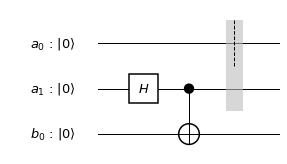

In [3]:
prepare = Q.QuantumCircuit(Alice, Bob)
prepare.h(Alice[1])
prepare.cx(Alice[1], Bob[0])
prepare.barrier()
prepare.draw(output='mpl')

Now, Alice will encode an arbitrary state into the qubit that has never interacted with Bob's system. For this example, we will use the superposition state $(\vert 0 \rangle + \vert 1 \rangle) / \sqrt{2}$. This can be achieved with a single application of the Hadarmard gate $H$.

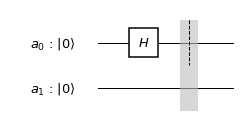

In [4]:
encode = Q.QuantumCircuit(Alice)
encode.h(Alice[0])
encode.barrier()
encode.draw(output='mpl')

Then, we will teleport this information. We will operate on and measure only Alice's half, storing information only in the classical ancillary register.

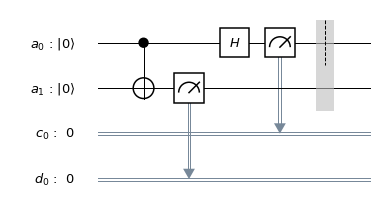

In [5]:
teleport = Q.QuantumCircuit(Alice, anc0, anc1)
teleport.cx(Alice[0], Alice[1])
teleport.h(Alice[0])
teleport.measure(Alice[0], anc0[0])
teleport.measure(Alice[1], anc1[0])
teleport.barrier()
teleport.draw(output='mpl')

Finally, using only the classical information in the ancillary bits, Bob, will reconstruct Alice's state like magic.

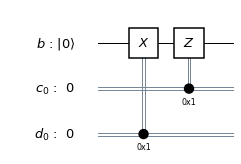

In [6]:
reconstruct = Q.QuantumCircuit(Bob, anc0, anc1)
reconstruct.x(Bob[0]).c_if(anc1, 1)
reconstruct.z(Bob[0]).c_if(anc0, 1)
reconstruct.draw(output='mpl')

Let's assemble the final circuit and see how it looks.

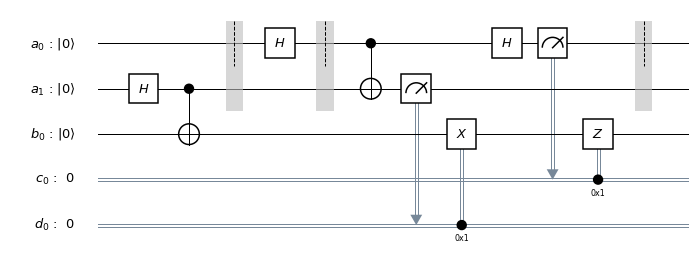

In [7]:
circuit = prepare + encode + teleport + reconstruct
circuit.draw(output='mpl')

Now let's try it out with the state vector simulator. Bob's qubit should end up in Alice's original state.

[0.   +0.j 0.707+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.707+0.j 0.   +0.j
 0.   +0.j]


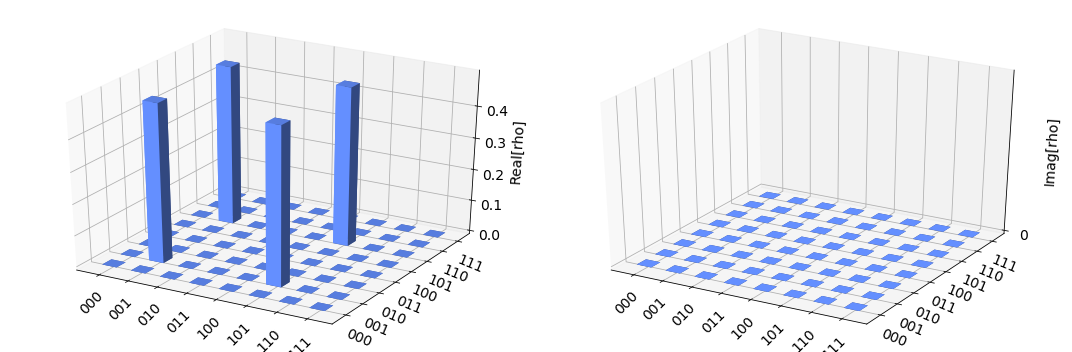

In [8]:
import qiskit.tools.visualization as viz

backend = Q.BasicAer.get_backend('statevector_simulator')
job = Q.execute(circuit, backend)
output = job.result().get_statevector(circuit, decimals=3)
print(output)
viz.plot_state_city(output)

And we get back exactly what we should: if we look at only Bob's qubit (the right-most one), we see that he is in the superposition state $(\vert 0 \rangle + \vert 1 \rangle) / \sqrt{2}$, exactly as he should be. I get different results for Alice's qubits whenever I run this (I think due to the projective measurement, which randomly puts them in one of the possible eigenstates), but Bob's results seem to be consistently good.